# Roteiro Levenberg-Marquadt

Esse código é um protótipo de função para a implementação do algoritmo de Levenberg-Marquadt, o qual é utilizado para estimar parâmetros não-lineares. 

\begin{equation}
\Gamma (\textbf{m}) = \Psi (\textbf{m}) + \mu \sum\limits^{6}_{j=1}\alpha_{j}\varphi_{j}(\textbf{m})
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
from fatiando import mesher, gridder, utils
from fatiando.gravmag import polyprism
from fatiando.mesher import PolygonalPrism
from fatiando.gravmag import prism
from fatiando.mesher import Prism
from fatiando.vis import mpl, myv
from fatiando.constants import CM, T2NT
from matplotlib import colors, ticker, cm
import mag_polyprism_functions as mfun
import polyprism_tests as tests
% matplotlib inline

/home/vital/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")
/home/vital/anaconda2/lib/python2.7/site-packages/fatiando/vis/myv.py:51: UserWarning: This module will be removed in v0.7.
  warnings.warn("This module will be removed in v0.7.")


# Entrada

### Parâmetros para o modelo direto

In [2]:
M = 6 # number of vertices per prism
L = 3 # number of prisms
P = L*(M+2) # number of parameters

inc, dec = -60., 50. # inclination and declination of regional field
incs, decs = 70., -50.      # wrong direction or remanent

#r = 1000. # radial distance for each vertice
r = np.zeros(M)
r[::2] = 3000.
r[1::2] = np.sqrt(2.)*3000.

# Cartesian coordinates of the origin of each prism
x0 = np.zeros(L) 
y0 = np.zeros(L)

dz = 100.0    # thickness of each prism

In [3]:
props={'magnetization': utils.ang2vec(3., inc, dec)} # physical property

z0 = 0.    # depth of the top the shallowest prism

l = []   # list of prisms

### creating the lis of prisms

for i in range(L):
    l.append([r, x0[i], y0[i], z0 + dz*i, z0 + dz*(i + 1), props])

### Pontos de observação

In [4]:
#area over which the data are calculated
#x minimum, x maximum, y minimum and y maximum
area = [-10000, 10000, -10000, 10000] 

#number of data along the y and x directions
shape = (80,80)

#total number of data
N = shape[0]*shape[1]

#coordinates x and y of the data
x = np.linspace(area[0],area[1],shape[0]) # points in x
y = np.linspace(area[2],area[3],shape[0]) # points in y
xp,yp = np.meshgrid(x,y)    # creating mesh points
xp = xp.ravel()
yp = yp.ravel()

#vertical coordinates of the data
zp = -350. - 500.*utils.gaussian2d(xp, yp, 17000, 21000, 21000, 18500, angle=21) # relief

### Parâmetros exigidos durante a inversão

In [5]:
lamb = 0.001 # Marquadt's parameter
dlamb = 5.  # step for Marquadt's parameter

# limits for parameters in meters
rmin = 100.
rmax = 6000.
x0min = -5000.
x0max = 5000.
y0min = -5000.
y0max = 5000.

delta = 10. # increment of derivatives

m_out = np.zeros(M + 2)  # outcropping body parameters

preg = 0.1000 # regularization parameter

# Gerando os dados preditos

In [6]:
m = mfun.param_vec(l, M, L) # true parameters vector

In [7]:
m

array([ 3000.        ,  4242.64068712,  3000.        ,  4242.64068712,
        3000.        ,  4242.64068712,     0.        ,     0.        ,
        3000.        ,  4242.64068712,  3000.        ,  4242.64068712,
        3000.        ,  4242.64068712,     0.        ,     0.        ,
        3000.        ,  4242.64068712,  3000.        ,  4242.64068712,
        3000.        ,  4242.64068712,     0.        ,     0.        ])

In [8]:
model = mfun.pol2cart(l, M, L) # list of classes of prisms

In [9]:
d = polyprism.tf(xp, yp, zp, model, inc, dec) # predict data

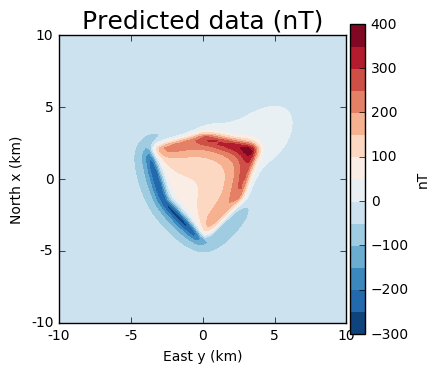

In [10]:
mpl.figure(figsize=(15,10))
mpl.subplot(1,3,1)
mpl.title("Predicted data (nT)", fontsize = 18)
mpl.axis('scaled')
nlevels = mpl.contourf(yp, xp, d,shape, 15, cmap='RdBu_r')
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4).set_label('nT')
mpl.m2km()
mpl.show()

# Algoritmo Levenberg-Marquadt

1- Iteração $k=0$: chute inicial $\mathbf{m}_0$ em que todos os elementos satisfaçam os vínculos de desigualdade e um valor real positivo grande para $\lambda$

2) Calcula os parâmetros transformados $\breve{\mathbf{m}}_k$

Os parâmetros transformados são calculados a partir da equação:

\begin{equation}
\breve{m}_i = f(m_i) = - \ln\left(\frac{m_{i\, max} - m_i}{m_i - m_{i\, min}}\right)
\end{equation}

A transformação inversa dos parâmetros é dada pela equação:

\begin{equation}
m_i = f^{-1}(\breve{m}_i) = m_{i\, min} + \left(\frac{m_{i\, max} - m_{i\, min}}{1 + e^{-\breve{m}_i}}\right)
\end{equation}

3) laço externo: calcula $\nabla^2\Gamma (\hat{\mathbf{m}}_k)$, $\nabla\Gamma (\hat{\mathbf{m}}_k)$ e $T(\hat{\mathbf{m}}_k)$:

In [11]:
#props={'magnetization': utils.ang2vec(3, inc, dec)} # physical property

#z0 = 0.    # depth of the top the shallowest prism

rini = np.full((M),(5000.))

lini = []   # list of parameters of each prisms

### creating the list of prisms
for i in range(L):
    lini.append([rini, x0[i], y0[i], z0 + dz*i, z0 + dz*(i + 1), props])

In [12]:
itmax = 50
itmax_marq = 15
epsilon = 0.001
m0 = mfun.param_vec(lini, M, L) # inicial parameters vector
model0 = mfun.pol2cart(lini, M, L) # list of classes of prisms
d0 = polyprism.tf(xp, yp, zp, model0, inc, dec) # predict data
dif = d - d0
phi0 = np.sum(dif*dif)
phi_list = [phi0]

for it in range(itmax):
    mt = mfun.trans_parameter(m0, M, L, rmin, rmax, x0min, x0max, y0min, y0max) # transformated parameters vector
    
    grad = mfun.gradient_data(xp, yp, zp, lini, M, L, d, delta, delta, delta, inc, dec)
    grad = mfun.gradient_phi_1(M, L, grad, preg)
    grad = mfun.gradient_phi_2(M, L, grad, preg)
    grad = mfun.gradient_phi_3(M, L, grad, m_out, preg)
    grad = mfun.gradient_phi_4(M, L, grad, m_out[-2:], preg)
    grad = mfun.gradient_phi_5(M, L, grad, preg)
    grad = mfun.gradient_phi_6(M, L, grad, preg)
    
    H = mfun.Hessian_data(xp, yp, zp, lini, M, L, delta, delta, delta, inc, dec)
    H = mfun.Hessian_phi_1(M, L, H, preg)
    H = mfun.Hessian_phi_2(M, L, H, preg)
    H = mfun.Hessian_phi_3(M, L, H, preg)
    H = mfun.Hessian_phi_4(M, L, H, preg)
    H = mfun.Hessian_phi_5(M, L, H, preg)
    H = mfun.Hessian_phi_6(M, L, H, preg)
    
    T = np.zeros(P)
    
    for i in range(0, L*(M+2), M+2):
        T[i:M+i] = (rmax - m0[i:M+i])*(m0[i:M+i] - rmin)/(rmax - rmin)
        T[M+i] = (rmax - m0[M+i])*(m0[M+i] - rmin)/(rmax - rmin)
        T[M+i+1] = (rmax - m0[M+i+1])*(m0[M+i+1] - rmin)/(rmax - rmin)
    
    i,j = np.diag_indices_from(H)
    H[i,j] += lamb
    H[i,:] *= T
    
    for it_marq in range(itmax_marq):
    
        delta_mt = np.linalg.solve(H, -grad)
        mt += delta_mt
        m_est = mfun.trans_inv_parameter(mt, M, L, rmin, rmax, x0min, x0max, y0min, y0max)
        model_est = mfun.param2model(m_est, M, L, z0, dz, props)
        d_est = polyprism.tf(xp, yp, zp, model_est, inc, dec)
        res = d - d0
        phi = np.sum(res*res)
        phi += preg*(mfun.phi_1(M, L, m_est, preg) + mfun.phi_2(M, L, m_est, preg) + \
                     mfun.phi_3(M, L, m_est, m_out, preg) + mfun.phi_4(M, L, m_est, m_out[-2:], preg) + \
                     mfun.phi_5(M, L, m_est, preg) + mfun.phi_6(M, L, m_est, preg))
        
        dphi = phi - phi0
        
        if (dphi > 0.):
            lamb *= dlamb
        else:
            lamb /= dlamb
            
    if ((phi0 - phi)/phi0 > epsilon):
        d0 = d_est
        m0 = m_est
        phi0 = phi
        phi_list.append(phi0)
    else:
        break

In [13]:
phi_list

[32551881.774074338]

In [14]:
mt

array([ 1.56810867,  1.57046964,  1.56083343,  1.56445997,  1.5721069 ,
        1.55778835, -0.21063637, -0.27164561,  1.56934943,  1.57058551,
        1.56448094,  1.56790131,  1.57263088,  1.56384602, -0.3159309 ,
       -0.40636755,  1.5712628 ,  1.57157224,  1.56693137,  1.57324141,
        1.5771549 ,  1.57028355, -0.36532683, -0.47020445])

In [15]:
np.exp(-mt)

array([ 0.20843904,  0.2079475 ,  0.20996101,  0.20920096,  0.20760731,
        0.21060133,  1.23446339,  1.31212191,  0.20818057,  0.20792341,
        0.20919657,  0.20848226,  0.20749856,  0.20932944,  1.37153548,
        1.50135428,  0.20778263,  0.20771834,  0.20868458,  0.20737191,
        0.20656195,  0.2079862 ,  1.44098489,  1.60032134])

In [16]:
lamb

30517578.125

In [17]:
np.log(1./0.)

ZeroDivisionError: float division by zero

In [ ]:
mpl.figure(figsize=(15,10))
mpl.subplot(1,3,1)
mpl.title("Predicted data (nT)", fontsize = 18)
mpl.axis('scaled')
nlevels = mpl.contourf(yp, xp, d0,shape, 15, cmap='RdBu_r')
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4).set_label('nT')
mpl.m2km()
mpl.show()

In [ ]:
ddif = d - d0
mpl.figure(figsize=(15,10))
mpl.subplot(1,3,1)
mpl.title("Predicted data (nT)", fontsize = 18)
mpl.axis('scaled')
nlevels = mpl.contourf(yp, xp, ddif,shape, 15, cmap='RdBu_r')
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4).set_label('nT')
mpl.m2km()
mpl.show()

In [ ]:
#m_volta = mfun.trans_inv_parameter(mt, M, L, rmin, rmax, x0min, x0max, y0min, y0max) # inverse transformation

#np.allclose(m_volta, m0) # validation test

# creating a model from the transformated parameters vector

#ltrans = [] # list of parameters of each prisms

#ii = i*(M+2)

### creating the list of prisms
#for i in range(L):
#    ltrans.append([mt[ii:ii+M], mt[ii+M], mt[ii+(M+1)], z0 + dz*i, z0 + dz*(i + 1), props])

#modeltrans = mfun.pol2cart(ltrans, M, L)

In [ ]:
m0[4:6] = 500.

In [ ]:
mp = mfun.trans_parameter(m0, M, L, rmin, rmax, x0min, x0max, y0min, y0max)

In [ ]:
mv = mfun.trans_inv_parameter(mp, M, L, rmin, rmax, x0min, x0max, y0min, y0max)

In [ ]:
mp

In [ ]:
mv

In [ ]:
mtt = np.zeros_like(m)

for i in range(0, P, M+2):
        mtt[i:M+i] = - np.log((rmax - m0[i:M+i])/(m0[i:M+i] - rmin))
        mtt[i+M] = - np.log((x0max - m0[i+M])/(m0[i+M] - x0min))
        mtt[i+M+1] = - np.log((y0max - m0[i+M+1])/(m0[i+M+1] - y0min))
        print (x0max - m0[i+M]), (m0[i+M] - x0min)
        print (y0max - m0[i+M+1]), (m0[i+M+1] - y0min)

In [ ]:
- np.log(31316.0714668/11316.0714668)

In [ ]:
mtt

a) laço interno: calcula $\Delta \breve{\mathbf{m}}_k$ solucionando o sistema linear abaixo

\begin{equation}
\left[\nabla^2\Gamma (\hat{\mathbf{m}}_k) + \lambda \mathbf{I} \right]\mathbf{T}(\hat{\mathbf{m}}_k) \Delta\breve{\mathbf{m}}_k \approx - \nabla \Gamma (\hat{\mathbf{m}}_k)
\end{equation}

onde $\mathbf{T}(\hat{\mathbf{m}}_k)$ é uma matriz diagonal
\begin{equation}
[\mathbf{T}(\hat{\mathbf{m}}_k)]_{ii} = \frac{(m_{i\, max} - m_i)(m_i - m_{i\, min})}{(m_{i\, max} - m_{i\, min})}
\end{equation}

b) calcula $\breve{\mathbf{m}}_{k+1} = \breve{\mathbf{m}}_k + \Delta\breve{\mathbf{m}}_k$

c) computa $\hat{\mathbf{m}}_{k+1}$

d) Enquanto $\Gamma (\hat{\mathbf{m}}_{k+1})<\Gamma (\hat{\mathbf{m}}_k)$ 

   i $\lambda = \lambda\cdot d\lambda$

   ii retorne para 3)a)

e) $\lambda = \lambda/d\lambda$

4) Enquanto $\Gamma (\hat{\mathbf{m}}_{k+1})<\Gamma (\hat{\mathbf{m}}_k)$ e $\frac{|\Gamma (\hat{\mathbf{m}}_{k+1})- \Gamma (\hat{\mathbf{m}}_k)|}{|\Gamma (\hat{\mathbf{m}}_k)|}>\varepsilon$

a) $k=k+1$

b) Retorne para etapa 2)

In [ ]:
P

In [ ]:
(10000. + 100.*np.exp(0.020202073175))/(np.exp(0.020202073175)+1)

In [ ]:
100. + 9900./(np.exp(0.020202073175)+1)